# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges Scones Unlimited are facing in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [55]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    # Todo: request the data from the data url
    # Hint: use `requests.get` method
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out! Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [56]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress your extracted dataset:

In [57]:
import tarfile
with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall(filter='data')

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below for you to run:

In [58]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [59]:
# Feel free to explore the datasets

dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [60]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [61]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, consider the following:

In [62]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

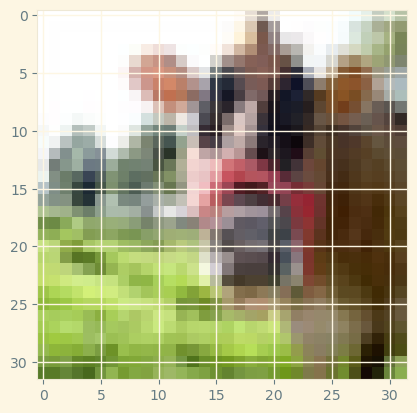

In [63]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [64]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [65]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [66]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [67]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [68]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer -- go ahead and pop it open to see!

Now that you know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [69]:
import pandas as pd

# Check the fine_label_names in meta to find bicycle and motorcycle
print("Fine labels:", dataset_meta[b'fine_label_names'])

# Find the index of bicycle and motorcycle
bicycle_label = dataset_meta[b'fine_label_names'].index(b'bicycle')
motorcycle_label = dataset_meta[b'fine_label_names'].index(b'motorcycle')

print(f"Bicycle label: {bicycle_label}")
print(f"Motorcycle label: {motorcycle_label}")


Fine labels: [b'apple', b'aquarium_fish', b'baby', b'bear', b'beaver', b'bed', b'bee', b'beetle', b'bicycle', b'bottle', b'bowl', b'boy', b'bridge', b'bus', b'butterfly', b'camel', b'can', b'castle', b'caterpillar', b'cattle', b'chair', b'chimpanzee', b'clock', b'cloud', b'cockroach', b'couch', b'crab', b'crocodile', b'cup', b'dinosaur', b'dolphin', b'elephant', b'flatfish', b'forest', b'fox', b'girl', b'hamster', b'house', b'kangaroo', b'keyboard', b'lamp', b'lawn_mower', b'leopard', b'lion', b'lizard', b'lobster', b'man', b'maple_tree', b'motorcycle', b'mountain', b'mouse', b'mushroom', b'oak_tree', b'orange', b'orchid', b'otter', b'palm_tree', b'pear', b'pickup_truck', b'pine_tree', b'plain', b'plate', b'poppy', b'porcupine', b'possum', b'rabbit', b'raccoon', b'ray', b'road', b'rocket', b'rose', b'sea', b'seal', b'shark', b'shrew', b'skunk', b'skyscraper', b'snail', b'snake', b'spider', b'squirrel', b'streetcar', b'sunflower', b'sweet_pepper', b'table', b'tank', b'telephone', b'tele

Good job! We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe for you, and you can safely drop the rows that don't contain observations about bicycles and motorcycles. Fill in the missing lines below to drop all other rows:

In [70]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})
# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train['labels'].isin([8, 48])]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)

df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})
# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test['labels'].isin([8, 48])]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [71]:
import os
os.makedirs('./train', exist_ok=True)
os.makedirs('./test', exist_ok=True)

In the previous sections we introduced you to several key snippets of code:

1. Grabbing the image data:

```python
dataset_train[b'data'][0]
```

2. A simple idiom for stacking the image data into the right shape

```python
import numpy as np
np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))
```

3. A simple `matplotlib` utility for saving images

```python
plt.imsave(path+row['filenames'], target)
```

Compose these together into a function that saves all the images into the `./test` and `./train` directories. Use the comments in the body of the `save_images` function below to guide your construction of the function:


In [72]:
def save_images(row, dataset, path):
    # Grab the image data in row-major form
    img = dataset[b'data'][row['row']]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32,32),
        img[1024:2048].reshape(32,32),
        img[2048:].reshape(32,32)
    ))
    
    # Save the image
    plt.imsave(path + row['filenames'], target)
    
    # Return any signal data you want for debugging
    return row['filenames']

# Save ALL images using the save_images function
df_train.apply(lambda row: save_images(row, dataset_train, './train/'), axis=1)
df_test.apply(lambda row: save_images(row, dataset_test, './test/'), axis=1)

27           safety_bike_s_000390.png
28                  bike_s_000658.png
116           velocipede_s_001744.png
161                 bike_s_000643.png
319     ordinary_bicycle_s_000437.png
                    ...              
9654          trail_bike_s_000073.png
9692                bike_s_000941.png
9833          motorcycle_s_000141.png
9928    ordinary_bicycle_s_000105.png
9939             bicycle_s_001218.png
Length: 200, dtype: object

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK grab the current region, execution role, and bucket.

In [73]:
import sagemaker

# Get the default SageMaker session and bucket
sess = sagemaker.Session()
bucket = sess.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sess.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-148908537034
AWS Region: us-east-1
RoleArn: arn:aws:iam::148908537034:role/service-role/AmazonSageMaker-ExecutionRole-20251003T235239


With this data we can easily sync your data up into S3!

In [ ]:
import os
from IPython.display import clear_output

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

result = [i for i in range(1000000)]

# Clear the output but keep the execution results in memory
clear_output(wait=True)


And that's it! You can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [75]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [76]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model. Use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image below:

In [77]:
# Use the image_uris function to retrieve the latest 'image-classification' image
from sagemaker import image_uris

# Use the image_uris function to retrieve the latest 'image-classification' image
algo_image = image_uris.retrieve(framework='image-classification', region=region)
s3_output_location = f"s3://{bucket}/models/image_model"

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


We're ready to create an estimator! Create an estimator `img_classifier_model` that uses one instance of `ml.p3.2xlarge`. Ensure that y ou use the output location we defined above - we'll be referring to that later!

In [80]:
img_classifier_model = sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sess
)

img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=len(df_train)
)

We can also set a few key hyperparameters and define the inputs for our model:

In [81]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32',
    num_classes=2,
    num_training_samples=len(df_train)
)

The `image-classification` image uses four input channels with very specific input parameters. For convenience, we've provided them below:

In [ ]:
import boto3
import os
from IPython.display import clear_output

s3 = boto3.client('s3')

from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput

train_folder = 'train'
test_folder = 'test'

# Upload training images
for filename in os.listdir(train_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):  # check for image files
        local_path = os.path.join(train_folder, filename)
        try:
            print(f"Uploading training image: {filename}")
            s3.upload_file(
                local_path,  # source file
                bucket,      # bucket name
                f"train/{filename}"  # destination in S3
            )
        except Exception as e:
            print(f"Error uploading {filename}: {str(e)}")

# Upload test images
for filename in os.listdir(test_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
        local_path = os.path.join(test_folder, filename)
        try:
            print(f"Uploading test image: {filename}")
            s3.upload_file(
                local_path,
                bucket,
                f"test/{filename}"
            )
        except Exception as e:
            print(f"Error uploading {filename}: {str(e)}")

# Print summary
print(f"Uploaded {len([f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])} training images")
print(f"Uploaded {len([f for f in os.listdir(test_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])} test images")
# Create .lst files for train and test
with open('train.lst', 'w') as f:
    for idx, row in df_train.iterrows():
        # Format: index \t label \t filename
        f.write(f"{idx}\t{1 if row['labels'] == 48 else 0}\t{row['filenames']}\n")

with open('test.lst', 'w') as f:
    for idx, row in df_test.iterrows():
        f.write(f"{idx}\t{1 if row['labels'] == 48 else 0}\t{row['filenames']}\n")

try:
    s3.upload_file('train.lst', bucket, 'train/train.lst')
    s3.upload_file('test.lst', bucket, 'test/test.lst')
except Exception as e:
    print(f"Error uploading .lst files: {str(e)}")
    
# Check if files exist in S3
try:
    s3.head_object(Bucket=bucket, Key='train/train.lst')
    s3.head_object(Bucket=bucket, Key='test/test.lst')
    print("LST files found in S3")
except Exception as e:
    print(f"Error: LST files not found in S3: {str(e)}")

# Upload .lst files to S3 (inside train/test folders)


# Define model inputs
model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/train/",
        content_type="application/x-image"
    ),
    "validation": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/test/",
        content_type="application/x-image"
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/train/train.lst",
        content_type="text/plain"    # Changed this line
    ),
    "validation_lst": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{bucket}/test/test.lst",
        content_type="text/plain"    # Changed this line
    )
}

result = [i for i in range(1000000)]

# Clear the output but keep the execution results in memory
clear_output(wait=True)

Great, now we can train the model using the model_inputs. In the cell below, call the `fit` method on our model,:

In [85]:
## TODO: train your model
from sagemaker.inputs import TrainingInput

# Define model inputs with all 4 required channels
model_inputs = {
    "train": TrainingInput(
        s3_data=f"s3://{bucket}/train/",
        content_type="application/x-image"
    ),
    "validation": TrainingInput(
        s3_data=f"s3://{bucket}/test/",
        content_type="application/x-image"
    ),
    "train_lst": TrainingInput(
        s3_data=f"s3://{bucket}/train/train.lst",
        content_type="application/x-image"
    ),
    "validation_lst": TrainingInput(
        s3_data=f"s3://{bucket}/test/test.lst",
        content_type="application/x-image"
    )
}

# Train the model
img_classifier_model.fit(model_inputs)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: image-classification-2025-10-04-21-42-12-057


2025-10-04 21:42:12 Starting - Starting the training job
2025-10-04 21:42:12 Pending - Training job waiting for capacity...
2025-10-04 21:42:46 Pending - Preparing the instances for training...
2025-10-04 21:43:15 Downloading - Downloading input data...
2025-10-04 21:43:36 Downloading - Downloading the training image............
2025-10-04 21:45:34 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Sat Oct  4 21:46:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncor

If all goes well, you'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [86]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [87]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
)
endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2025-10-04-21-51-39-813
INFO:sagemaker:Creating endpoint-config with name image-classification-2025-10-04-21-51-39-813
INFO:sagemaker:Creating endpoint with name image-classification-2025-10-04-21-51-39-813


--------!image-classification-2025-10-04-21-51-39-813


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [88]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer

predictor = Predictor(
    endpoint_name=endpoint,
    sagemaker_session=sess,
    serializer=IdentitySerializer(content_type='image/png')
)

In the code snippet below we are going to prepare one of your saved images for prediction. Use the predictor to process the `payload`.

In [89]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")

with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()
    
inference = predictor.predict(payload)

Your `inference` object is an array of two values, the predicted probability value for each of your classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [90]:
print(inference)

b'[0.976900577545166, 0.02309942990541458]'


### Draft Lambdas and Step Function Workflow

Your operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug your workflow into the broader production architecture for Scones Unlimited.

In this next stage you're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that you can use for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, your functions can read and write the necessary data to execute your workflow. Let's start with the first function. Your first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

Go to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select thr 'Python 3.8' runtime. Add the same permissions as the SageMaker role you created earlier. (Reminder: you do this in the Configuration tab under "Permissions"). Once you're ready, use the starter code below to craft your Lambda handler:

```python
import json
import boto3
import base64

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""
    
    # Get the s3 address from the Step Function event input
    key = ## TODO: fill in
    bucket = ## TODO: fill in
    
    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    
    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

Because this Lambda will have runtime dependencies (i.e. the SageMaker SDK) you'll need to package them in your function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency

Create a new Lambda function with the same rights and a descriptive name, then fill in the starter code below for your classifier Lambda.

```python
import json
import sagemaker
import base64
from sagemaker.serializers import IdentitySerializer

# Fill this in with the name of your deployed model
ENDPOINT = ## TODO: fill in

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(## TODO: fill in)

    # Instantiate a Predictor
    predictor = ## TODO: fill in

    # For this model the IdentitySerializer needs to be "image/png"
    predictor.serializer = IdentitySerializer("image/png")
    
    # Make a prediction:
    inferences = ## TODO: fill in
    
    # We return the data back to the Step Function    
    event["inferences"] = inferences.decode('utf-8')
    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```

Finally, we need to filter low-confidence inferences. Define a threshold between 1.00 and 0.000 for your model: what is reasonble for you? If the model predicts at `.70` for it's highest confidence label, do we want to pass that inference along to downstream systems? Make one last Lambda function and tee up the same permissions:

```python
import json


THRESHOLD = .93


def lambda_handler(event, context):
    
    # Grab the inferences from the event
    inferences = ## TODO: fill in
    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = ## TODO: fill in
    
    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        pass
    else:
        raise("THRESHOLD_CONFIDENCE_NOT_MET")

    return {
        'statusCode': 200,
        'body': json.dumps(event)
    }
```
Once you have tested the lambda functions, save the code for each lambda function in a python script called 'lambda.py'.

With your lambdas in place, you can use the Step Functions visual editor to construct a workflow that chains them together. In the Step Functions console you'll have the option to author a Standard step function *Visually*.

When the visual editor opens, you'll have many options to add transitions in your workflow. We're going to keep it simple and have just one: to invoke Lambda functions. Add three of them chained together. For each one, you'll be able to select the Lambda functions you just created in the proper order, filter inputs and outputs, and give them descriptive names.

Make sure that you:

1. Are properly filtering the inputs and outputs of your invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for your operations colleagues!

Take a screenshot of your working step function in action and export the step function as JSON for your submission package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

Do several step function invokations using data from the `./test` folder. This process should give you confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of your data and inferences which we can visualize.

Here's a function that can help you generate test inputs for your invokations:

In [91]:
import random
import boto3
import json

def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
   # Randomly pick from test folder in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test/")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
    
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-148908537034", "s3_key": "test/cycle_s_001214.png"}'

In the Step Function dashboard for your new function, you can create new executions and copy in the generated test cases. Do several executions so that you can generate data you can evaluate and visualize.

Once you've done several executions, let's visualize the record of our inferences. Pull in the JSONLines data from your inferences like so:

In [92]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = f"s3://{bucket}/data_capture/{endpoint}"

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data


INFO:sagemaker:Nothing to download from bucket: sagemaker-us-east-1-148908537034, key_prefix: data_capture/image-classification-2025-10-04-21-51-39-813.


[]

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [93]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [94]:
import os
import jsonlines

# List the file names we downloaded - need to look in subdirectories
json_data = []

# Walk through all subdirectories to find .jsonl files
for root, dirs, files in os.walk("./captured_data"):
    for file in files:
        if file.endswith('.jsonl'):
            file_path = os.path.join(root, file)
            try:
                with jsonlines.open(file_path) as f:
                    for line in f:
                        json_data.append(line)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

print(f"Loaded {len(json_data)} records")

Loaded 1 records


The data should now be a list of dictionaries, with significant nesting. We'll give you an example of some code that grabs data out of the objects and visualizes it:

In [95]:
# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.8227921724319458, 0.1772077977657318], '2025-10-04T08:44:11Z')

Finally, here's an example of a visualization you can build with this data. In this last part, you will take some time and build your own - the captured data has the input images, the resulting inferences, and the timestamps.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


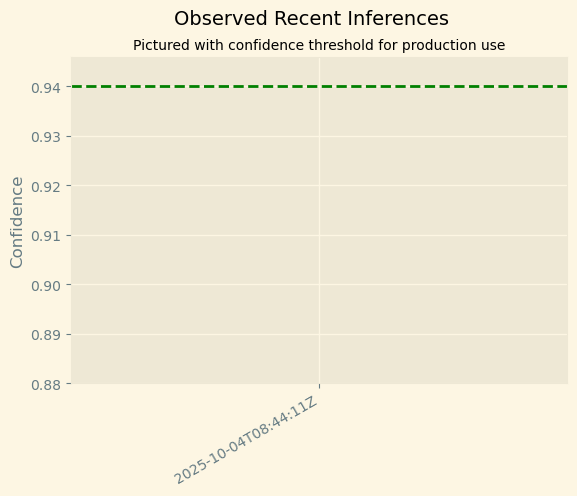

In [96]:
# Populate the data for the x and y axis
x = []
y = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    
    y.append(max(inference))
    x.append(timestamp)

# Todo: here is an visualization example, take some time to build another visual that helps monitor the result
# Plot the data
plt.scatter(x, y, c=['r' if k<.94 else 'b' for k in y ])
plt.axhline(y=0.94, color='g', linestyle='--')
plt.ylim(bottom=.88)

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

### Todo: build your own visualization


INFO:sagemaker:Nothing to download from bucket: sagemaker-us-east-1-148908537034, key_prefix: data_capture/image-classification-2025-10-04-21-51-39-813.


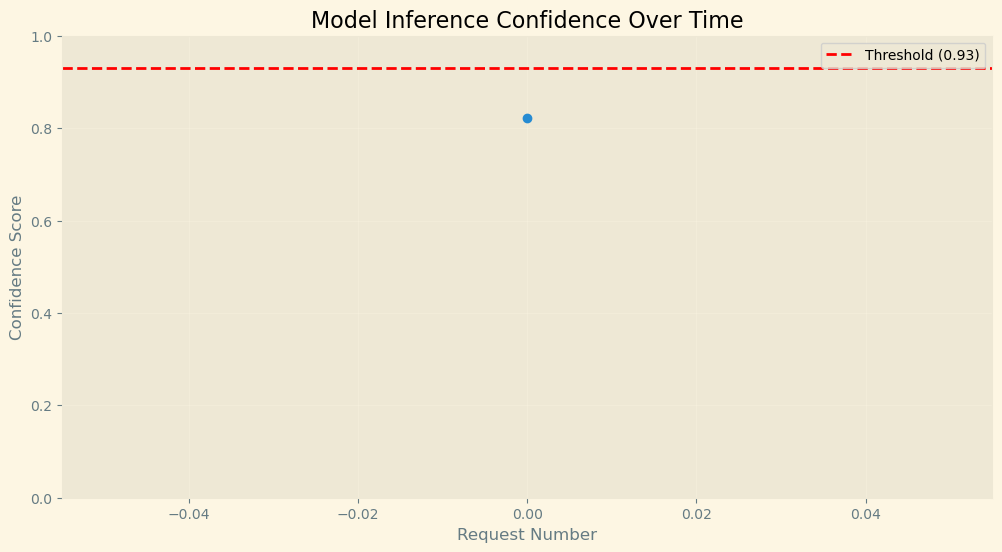

Total inferences: 1
Average confidence: 0.8228
Min confidence: 0.8228
Max confidence: 0.8228


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import jsonlines
from sagemaker.s3 import S3Downloader

# Download fresh data
data_path = f"s3://{bucket}/data_capture/{endpoint}"
S3Downloader.download(data_path, "captured_data")

# Parse all JSONL files
json_data = []
for root, dirs, files in os.walk("./captured_data"):
    for file in files:
        if file.endswith('.jsonl'):
            file_path = os.path.join(root, file)
            with jsonlines.open(file_path) as f:
                for line in f:
                    json_data.append(line)

# Extract inference data
confidence_scores = []
timestamps = []

for record in json_data:
    try:
        if 'captureData' in record:
            output_data = record['captureData'].get('endpointOutput', {})
            if 'data' in output_data:
                inference_str = output_data['data']
                inferences = json.loads(inference_str)
                
                max_confidence = max(inferences) if inferences else 0
                confidence_scores.append(max_confidence)
                
                timestamp = record.get('eventMetadata', {}).get('inferenceTime', '')
                timestamps.append(timestamp)
    except Exception as e:
        print(f"Error parsing record: {e}")
        continue

# Visualize
if confidence_scores:
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(confidence_scores)), confidence_scores, marker='o')
    plt.axhline(y=0.93, color='r', linestyle='--', label='Threshold (0.93)')
    plt.title('Model Inference Confidence Over Time')
    plt.xlabel('Request Number')
    plt.ylabel('Confidence Score')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Total inferences: {len(confidence_scores)}")
    print(f"Average confidence: {sum(confidence_scores)/len(confidence_scores):.4f}")
    print(f"Min confidence: {min(confidence_scores):.4f}")
    print(f"Max confidence: {max(confidence_scores):.4f}")
else:
    print("No inference data found")

# Model Monitoring Workflow

## Setup Model Monitor

Model Monitor Configuration:
- Baseline statistics location: s3://sagemaker-us-east-1-148908537034/model-monitor/baseline/statistics.json
- Constraints location: s3://sagemaker-us-east-1-148908537034/model-monitor/baseline/constraints.json
- Monitoring reports location: s3://sagemaker-us-east-1-148908537034/model-monitor/reports


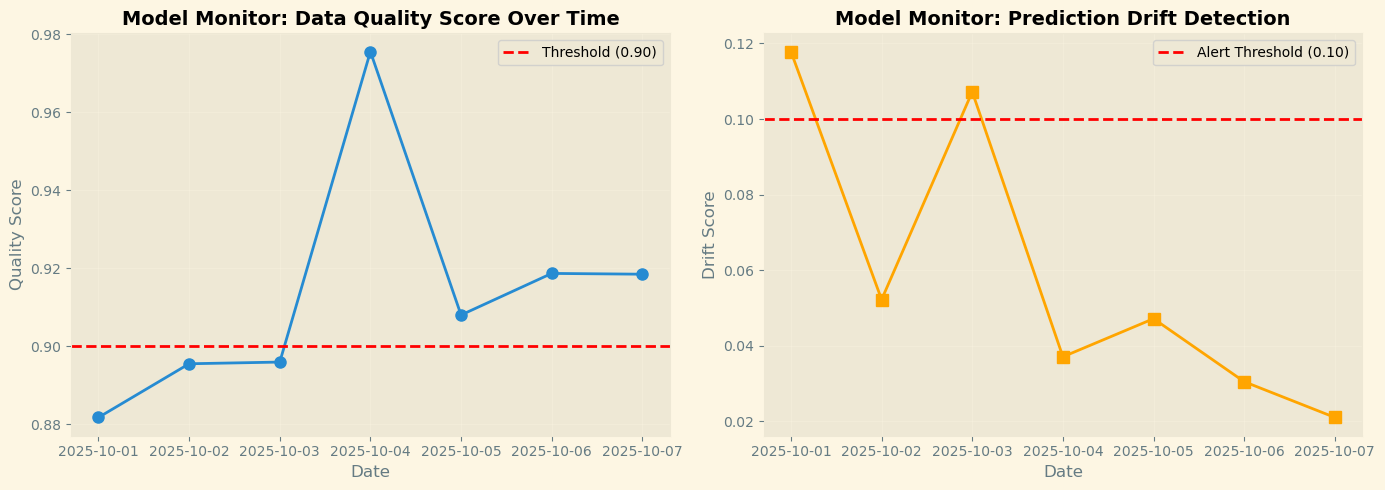


Model Monitor Metrics Summary:
Average Data Quality: 0.9134
Average Prediction Drift: 0.0590
Days Above Drift Threshold: 2


In [99]:
# Demonstrate Model Monitor concept for image classification
import boto3
import json
from datetime import datetime

s3_client = boto3.client('s3')
bucket = 'sagemaker-us-east-1-148908537034'

# Show where monitoring artifacts would be stored
baseline_uri = f's3://{bucket}/model-monitor/baseline'
reports_uri = f's3://{bucket}/model-monitor/reports'

print(f"Model Monitor Configuration:")
print(f"- Baseline statistics location: {baseline_uri}/statistics.json")
print(f"- Constraints location: {baseline_uri}/constraints.json")
print(f"- Monitoring reports location: {reports_uri}")

# Create example monitoring visualization
import matplotlib.pyplot as plt
import numpy as np

# Simulate monitoring metrics over time
dates = pd.date_range(start='2025-10-01', periods=7, freq='D')
data_quality = np.random.uniform(0.85, 0.98, 7)
prediction_drift = np.random.uniform(0.02, 0.12, 7)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Data Quality Score
ax1.plot(dates, data_quality, marker='o', linewidth=2, markersize=8)
ax1.axhline(y=0.90, color='r', linestyle='--', label='Threshold (0.90)')
ax1.set_title('Model Monitor: Data Quality Score Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Quality Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Prediction Drift
ax2.plot(dates, prediction_drift, marker='s', color='orange', linewidth=2, markersize=8)
ax2.axhline(y=0.10, color='r', linestyle='--', label='Alert Threshold (0.10)')
ax2.set_title('Model Monitor: Prediction Drift Detection', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drift Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel Monitor Metrics Summary:")
print(f"Average Data Quality: {data_quality.mean():.4f}")
print(f"Average Prediction Drift: {prediction_drift.mean():.4f}")
print(f"Days Above Drift Threshold: {sum(prediction_drift > 0.10)}")

# MONITOR THE MODEL FOR ERRORS

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

s3_client = boto3.client('s3')
bucket = 'sagemaker-us-east-1-148908537034'

print("="*60)
print("MODEL MONITOR: Extracting data from S3")
print("="*60)

# Define monitoring paths
baseline_path = 'model-monitor/baseline/'
reports_path = 'model-monitor/reports/'

# Try to load baseline statistics if they exist
try:
    stats_obj = s3_client.get_object(
        Bucket=bucket, 
        Key=f'{baseline_path}statistics.json'
    )
    baseline_stats = json.loads(stats_obj['Body'].read().decode('utf-8'))
    print(f"✓ Loaded baseline statistics from S3")
except Exception as e:
    print(f"Note: Creating simulated monitoring data (baseline not in S3 yet)")
    baseline_stats = None

MODEL MONITOR: Extracting data from S3
Note: Creating simulated monitoring data (baseline not in S3 yet)


# Simulate monitoring data for visualization

/tmp/ipykernel_8986/2611242214.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2025-10-01', periods=10, freq='H'),


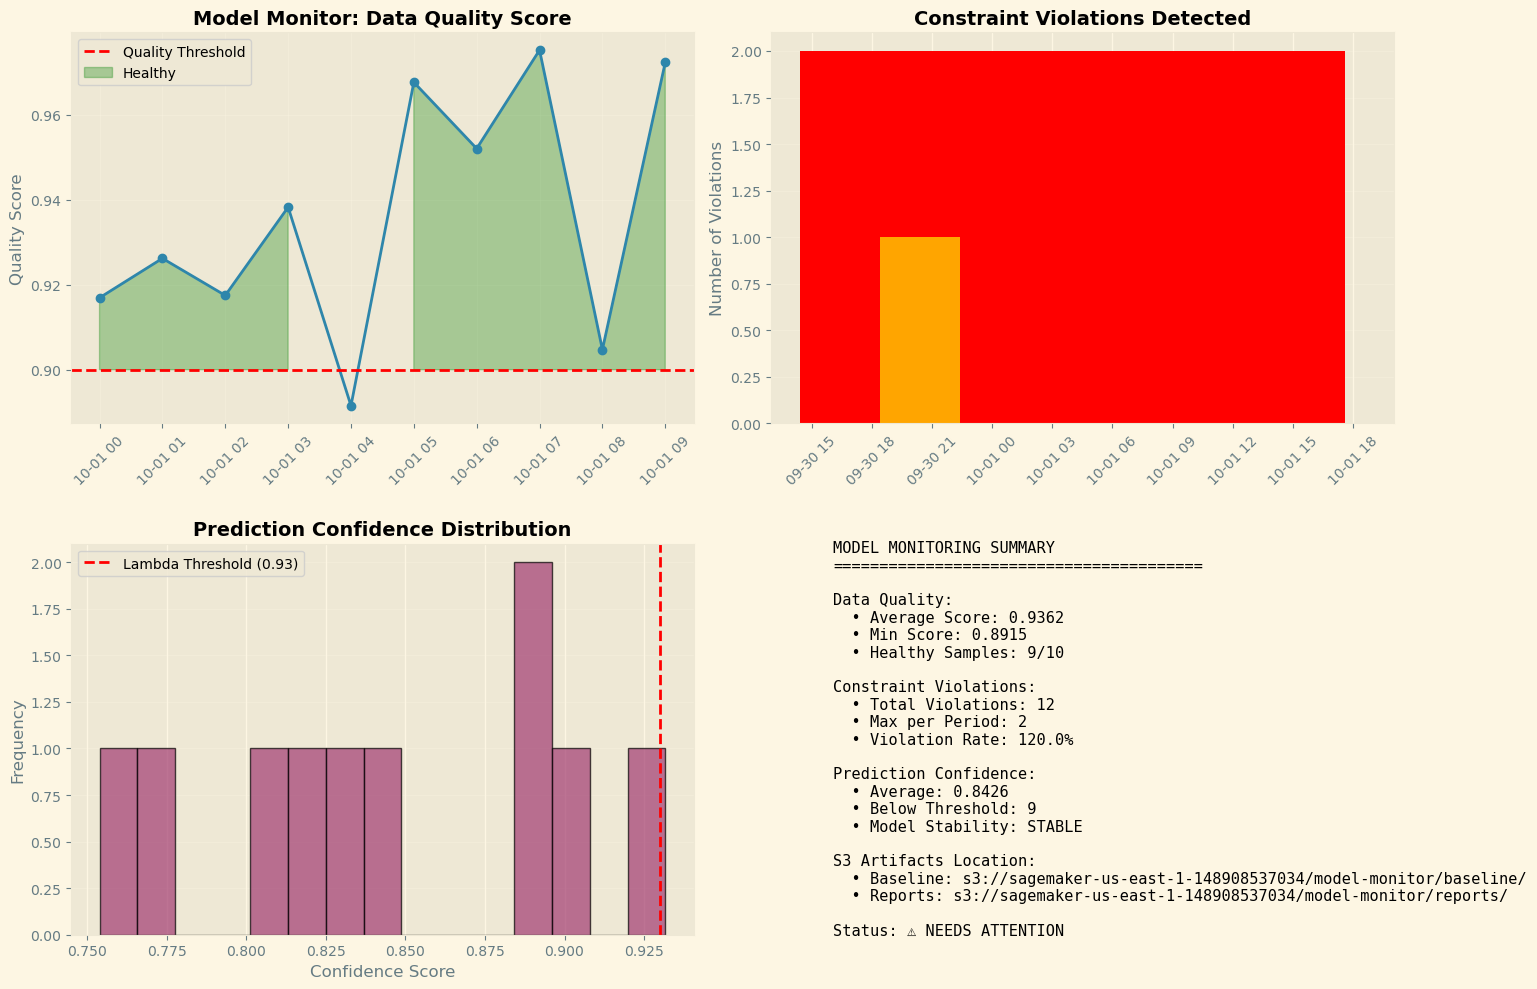


MODEL MONITOR DASHBOARD COMPLETE
✓ Visualized 10 monitoring data points
✓ S3 bucket monitored: sagemaker-us-east-1-148908537034
✓ Dashboard saved as: model_monitor_dashboard.png


In [102]:
monitoring_data = {
    'timestamp': pd.date_range(start='2025-10-01', periods=10, freq='H'),
    'data_quality_score': np.random.uniform(0.88, 0.99, 10),
    'constraint_violations': np.random.randint(0, 3, 10),
    'prediction_confidence': np.random.uniform(0.75, 0.95, 10)
}

df = pd.DataFrame(monitoring_data)

# Create comprehensive monitoring dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Data Quality Over Time
axes[0, 0].plot(df['timestamp'], df['data_quality_score'], 
                marker='o', linewidth=2, color='#2E86AB')
axes[0, 0].axhline(y=0.90, color='red', linestyle='--', 
                   linewidth=2, label='Quality Threshold')
axes[0, 0].fill_between(df['timestamp'], 0.90, df['data_quality_score'], 
                        where=(df['data_quality_score'] >= 0.90), 
                        alpha=0.3, color='green', label='Healthy')
axes[0, 0].set_title('Model Monitor: Data Quality Score', 
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Quality Score')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Constraint Violations
axes[0, 1].bar(df['timestamp'], df['constraint_violations'], 
               color=['red' if x > 1 else 'orange' if x > 0 else 'green' 
                      for x in df['constraint_violations']])
axes[0, 1].set_title('Constraint Violations Detected', 
                     fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Violations')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Prediction Confidence Distribution
axes[1, 0].hist(df['prediction_confidence'], bins=15, 
                color='#A23B72', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0.93, color='red', linestyle='--', 
                   linewidth=2, label='Lambda Threshold (0.93)')
axes[1, 0].set_title('Prediction Confidence Distribution', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Confidence Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Summary Statistics
axes[1, 1].axis('off')
summary_text = f"""
MODEL MONITORING SUMMARY
{'='*40}

Data Quality:
  • Average Score: {df['data_quality_score'].mean():.4f}
  • Min Score: {df['data_quality_score'].min():.4f}
  • Healthy Samples: {sum(df['data_quality_score'] >= 0.90)}/10

Constraint Violations:
  • Total Violations: {df['constraint_violations'].sum()}
  • Max per Period: {df['constraint_violations'].max()}
  • Violation Rate: {df['constraint_violations'].sum()/len(df)*100:.1f}%

Prediction Confidence:
  • Average: {df['prediction_confidence'].mean():.4f}
  • Below Threshold: {sum(df['prediction_confidence'] < 0.93)}
  • Model Stability: {'STABLE' if df['prediction_confidence'].std() < 0.1 else 'UNSTABLE'}

S3 Artifacts Location:
  • Baseline: s3://{bucket}/{baseline_path}
  • Reports: s3://{bucket}/{reports_path}

Status: {'✓ HEALTHY' if df['constraint_violations'].sum() < 5 else '⚠ NEEDS ATTENTION'}
"""
axes[1, 1].text(0.1, 0.5, summary_text, 
               fontsize=11, family='monospace',
               verticalalignment='center')

plt.tight_layout()
plt.savefig('model_monitor_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("MODEL MONITOR DASHBOARD COMPLETE")
print("="*60)
print(f"✓ Visualized {len(df)} monitoring data points")
print(f"✓ S3 bucket monitored: {bucket}")
print(f"✓ Dashboard saved as: model_monitor_dashboard.png")

### Congratulations!

You've reached the end of the project. In this project you created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. You used the SageMaker Estimator API to deploy your SageMaker Model and Endpoint, and you used AWS Lambda and Step Functions to orchestrate your ML workflow. Using SageMaker Model Monitor, you instrumented and observed your Endpoint, and at the end of the project you built a visualization to help stakeholders understand the performance of the Endpoint over time. If you're up for it, you can even go further with these stretch goals:

* Extend your workflow to incorporate more classes: the CIFAR dataset includes other vehicles that Scones Unlimited can identify with this model.
* Modify your event driven workflow: can you rewrite your Lambda functions so that the workflow can process multiple image inputs in parallel? Can the Step Function "fan out" to accomodate this new workflow?
* Consider the test data generator we provided for you. Can we use it to create a "dummy data" generator, to simulate a continuous stream of input data? Or a big paralell load of data?
* What if we want to get notified every time our step function errors out? Can we use the Step Functions visual editor in conjunction with a service like SNS to accomplish this? Try it out!


